# Import libraries.

In [1]:
# compare the data/mc veto efficiencies for jet veto and rechit vetos

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
import awkward as ak
from coffea.nanoevents.methods import vector, candidate
import math
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys
from numba import jit
import pandas as pd
import pdb
# if not sys.warnoptions:
import warnings

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys
import imageio.core.util

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warns_ = silence_imageio_warning

warnings.simplefilter("ignore")

def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while np.count_nonzero(ak.flatten(dphi) > math.pi):
        dphi = dphi - (dphi > math.pi)*2*math.pi
    while np.count_nonzero(ak.flatten(dphi) <= -math.pi):
        dphi = dphi + (dphi <= -math.pi)*2*math.pi
    return dphi
lumi = 41600

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.24/06


/uscms_data/d3/ahayrape/mamba/envs/btollpk/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'FileNotFoundError([Errno 2] No such file or directory: '/uscms_data/d3/ahayrape/mamba/envs/btollpk/lib/python3.9/site-packages/numpy-1.23.2.dist-info/METADATA')'.
  numba.core.entrypoints.init_all()


3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]


# Load datasets.

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
years = ['17']
category = 0
ver = 'V1p17'
sig_ver = 'v52'
singleMuon = True
bkg_path = '/eos/uscms/store/user/ahayrape/DY_BParking_v2/'

if sig_ver == 'v52':fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
else:fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_137000pb_weighted.root'
for y in years:
    data_path = "/eos/uscms/store/user/ahayrape/DY_BParking_v2/"
    if y == '16':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    elif y == '17':fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    else:fpath_bkg['data'+y] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"

signal_samples_dir = "/eos/uscms/store/user/ahayrape/Signal_datasets"
signal_samples = os.listdir(signal_samples_dir)
for i in signal_samples:
    fpath_bkg[i.split(".root")[0]] = f"{signal_samples_dir}/{i}"

for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']

lumi = 41600

dy_120_800 /eos/uscms/store/user/ahayrape/DY_BParking_v2/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
data17 /eos/uscms/store/user/ahayrape/DY_BParking_v2/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
PhiToPi0Pi0_mPhi0p3_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPi0Pi0_mPhi0p3_ctau300.root
PhiToPi0Pi0_mPhi1p0_ctau1000 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPi0Pi0_mPhi1p0_ctau1000.root
PhiToPiPlusPiMinus_mPhi0p3_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi0p3_ctau300.root
PhiToPiPlusPiMinus_mPhi1p0_ctau1000 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi1p0_ctau1000.root
PhiToPiPlusPiMinus_mPhi1p0_ctau300 /eos/uscms/store/user/ahayrape/Signal_datasets/PhiToPiPlusPiMinus_mPhi1p0_ctau300.root


# Get variables and cutflow tables.

In [3]:
###########
# 0: RPC matching veto; 1:muon veto; 2: MB1 veto; 3: MB1 adjacent veto; 4: Jet veto;
###########

veto = 6
veto_names = ['rpc_matching_veto'           , 'muon_veto'           , 'mb1_veto'           , 'mb1_adjacent_veto'           , 'jet_veto', 'rec_seg_veto', 'probe_muon_cluster'] # For DT
veto_yaxis = ['RPC matching Veto efficiency', 'Muon Veto Efficiency', 'MB1 Veto Efficiency', 'MB1 adjacent Veto Efficiency', 'Jet Veto', 'Rechit/Segment Veto', 'Probe muon cluster']

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
nJets = {}
sel_lep = {}
sel_ev = {}
mc_corr_weight = {}
lepOverallSF = {}
nJets2 = {}
jetPt = {}
jetPhi = {}
jetEta = {}
muonPt = {}
muonPhi = {}
muonEta = {}
clusterSize = {}
nMuons = {}
npu = {}
npv = {}

cscRechitClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitCluster_match_gLLP_other_decay_r = {}
cscRechitCluster_match_gLLP_other_decay_z = {}
cscRechitClusterRE12 = {}
cscRechitClusterRB1 = {}
cscRechitClusterMB1 = {}
cscRechitClusterME11 = {}
cscRechitClusterMB1Rechit = {}
cscRechitClusterME12 = {}

dtRechitClusterJetVetoPt = {}
dtRechitClusterEta = {}
dtRechitClusterPhi = {}
dtRechitClusterWheel = {}
dtRechitClusterSize = {}

re12_eta = {}
re12_phi = {}
rb1_eta = {}
rb1_phi = {}
mb1_phi = {}
mb1_eta = {}
mb1_rechit_eta = {}
mb1_rechit_phi = {}
me11_eta = {}
me11_phi = {}
me12_eta = {}
me12_phi = {}
corr_eta = {}
corr_phi = {}
all_eta = {}
all_phi = {}
wheels = {}
stations = {}

rpc_ring = {}
rpc_eta  = {}
rpc_phi  = {}

me1112_veto_eta = {}
me1112_veto_phi = {}
re12_seg_eta = {}
re12_seg_phi = {}
mb1_seg_eta = {}
mb1_seg_phi = {}
rb1_eta = {}
rb1_phi = {}
cut_based_ID_eta = {}
cut_based_ID_phi = {}
eta_cut_eta = {}
eta_cut_phi = {}

RPC_Bx_eta = {}
RPC_Bx_phi = {}
RPC_Hits_eta = {}
RPC_Hits_phi = {}
RPC_Hits_phi = {}
RPC_Hits_eta = {}
mb1_phi = {}
mb1_eta = {}
rechit_phi = {}
rechit_eta = {}
dr_mb1 = {}
probe_muonPhi = {}
probe_muonEta = {}
probe_sel = {}

muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
cluster_index = ''

for k, T in tree_bkg.items():
########## select cluster ########
    arrays = T.arrays()
    sel_rechitcluster = np.ones(len(arrays['dtRechitCluster' + cluster_index + 'Eta']), dtype = bool)

# ########### BRANCHES ############
    if "PhiTo" in k:

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        muon = (np.abs(arrays["lepPdgId"]) == 13)
        m_eta = arrays["lepEta"][muon]
        m_phi = arrays["lepPhi"][muon]
        m_pt  = arrays["lepPt" ][muon]
        m_DZ  = arrays["lepDZ" ][muon]
        m_HLT = arrays["lepMuon_passHLTFilter"][muon]
        m_LooseId = arrays["lepLooseId"][muon]
        m_TightId = arrays["lepTightId"][muon]
        m_Type = arrays["lepMuonType"][muon]
        m_Quality = arrays["lepMuonQuality"][muon]
        m_passHLTFilter = arrays["lepMuon_passHLTFilter"][muon]

        selections = (m_eta < 1.5) & (m_pt > 7) & (ak.any(m_HLT[:,:,range(60,68)], axis=2)) & (m_Quality >= 2**25) #
        m_eta = m_eta[selections]
        m_phi = m_phi[selections]
        m_pt  = m_pt [selections]

        # leadcut = (ak.max(m_pt, axis=1, mask_identity=True) == m_pt) ##
        # m_eta = m_eta[leadcut]
        # m_phi = m_phi[leadcut]
        # m_pt  = m_pt [leadcut]

        # For DT
        pairs = ak.cartesian({
            "RechitClusters": ak.zip({"eta": arrays['dtRechitClusterEta'], \
                                      "phi": arrays['dtRechitClusterPhi']}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior),
            "muons"         : ak.zip({"eta": m_eta, \
                                      "phi": m_phi}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior)
        }, nested = True)

        dr = (pairs.muons).delta_r(pairs.RechitClusters)
        DR_cls_muons = ak.any(dr > 0.8, axis = 2)
        dphi = (pairs.muons).delta_phi(pairs.RechitClusters)
        DPHI_cls_muons = ak.any(dphi > 2.4, axis = 2)
    
        del pairs
        del dr
        del dphi
        
        pairs = ak.cartesian({
            "RechitClusters": ak.zip({"eta": arrays['dtRechitClusterEta'], \
                                      "phi": arrays['dtRechitClusterPhi']}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior),
            "llps"          : ak.zip({"eta": arrays['gLLP_eta'], \
                                      "phi": arrays['gLLP_phi']}, with_name = 'PtEtaPhiMLorentzVector', behavior = vector.behavior)
        }, nested = True)
        dr = (pairs.llps).delta_r(pairs.RechitClusters)
        DR_cls_llp = ak.any(dr < 0.4, axis = 2)
        del pairs
        del dr

        names = [
            # 'cluster_size',
            'RPC matching',
            'LLP_matching',
            'Muon_cluster rejection',
            'RPC matching',
            'MB1_veto',
            'RPC_Bx',
            'MB1_cosmics',
            # 'cluster_size_220'
        ]

        veto_sel = [ # DT selections
            # arrays['dtRechitClusterSize'] >= 50, # cluster size response
            DR_cls_llp,
            DR_cls_muons,
            arrays['dtRechitCluster_match_RPChits_dPhi0p5'] > 0,
            arrays['dtRechitClusterMuonVetoPt'] < 20,
            arrays['dtRechitCluster_match_MB1hits_0p5'] <= 1,
            arrays['dtRechitCluster_match_RPCBx_dPhi0p5'] == 0,
            np.logical_and(arrays['dtRechitCluster_match_MB1hits_cosmics_plus'] <= 8, arrays['dtRechitCluster_match_MB1hits_cosmics_plus'] <= 8),
            arrays['dtRechitClusterMaxStation'] >= 3,
            DPHI_cls_muons,
            # arrays['dtRechitClusterSize'] >= 220, # cluster reconstruction
        ]

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        for v in veto_sel:
            sel_rechitcluster = np.logical_and(sel_rechitcluster, v)
        # no_mb1_clusters = (arrays["dtRechitClusterMaxStation"] != 1)
        # sel_rechitcluster = np.logical_and(sel_rechitcluster, no_mb1_clusters)

        HLT_MU_IP_sel = range(1157, 1197)
        sel_ev[k] = ak.any(arrays['HLTDecision'][:,HLT_MU_IP_sel], axis = 1)
        sel_ev[k] = np.logical_and(sel_ev[k], (arrays['nDtRechitClusters'] > 0))
        sel_ev[k] = np.logical_and(sel_ev[k], (arrays['gLLP_dt'] > 0))

        print(f'\n{k}')
        prev_number = 1.0
        cutflow_table = veto_sel[0]
        print(f'0) - ({names[0]}) - {100.0 * np.sum(cutflow_table)/prev_number}')
        #for s in range(len(veto_sel)):
        #    if s == 0: continue
        #    prev_number = np.sum(ak.any(cutflow_table, axis=1))
        #    cutflow_table = np.logical_and(cutflow_table, veto_sel[s])
        #    print(f'{s}) - ({names[s]}) - {100.0 * np.sum(cutflow_table)/prev_number}')

        # no_clusters = (ak.count( arrays['dtRechitCluster' + cluster_index + 'Eta'][sel_rechitcluster][sel_ev[k]], axis = 1) > 0)
        no_clusters = (ak.count( arrays['dtRechitCluster' + cluster_index + 'Eta'][sel_rechitcluster][sel_ev[k]], axis = 1) > 0)
        dtRechitClusterEta[k] = arrays['dtRechitCluster' + cluster_index + 'Eta'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        dtRechitClusterPhi[k] = arrays['dtRechitCluster' + cluster_index + 'Phi'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        dtRechitClusterWheel[k] = arrays['dtRechitCluster' + cluster_index + 'Wheel'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        dtRechitClusterSize[k] = arrays['dtRechitCluster' + cluster_index + 'Size'][sel_rechitcluster][sel_ev[k]][no_clusters][:,0]
        nMuons[k] = ak.count(m_eta, axis = 1)[sel_ev[k]][no_clusters]
        weight[k] = (arrays['weight'])[sel_ev[k]][no_clusters]
    else:
        sel_lep[k] = np.logical_and(arrays['lepTightId']==1, arrays["lepPassTightIso"]==1) # tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(arrays["lepPdgId"])==13)            # tight iso+id lepton
        sel_ev[k] = np.sum(sel_lep[k], axis = 1)>=1
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(arrays['lepPt']>= muonPt, axis = 1)==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], np.sum(arrays['lepFromZ'], axis = 1)==2)
        sel_ev[k] = np.logical_and(sel_ev[k], arrays["Flag2_all"])
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['category']==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['ZMass']>=120)
        sel_ev[k] = np.logical_and(sel_ev[k], arrays['ZMass']<800)
        weight[k] = arrays['weight'][sel_ev[k]]*lumi
        pileupWeight[k] = arrays['pileupWeight'][sel_ev[k]]
        if k[:2] == 'dy': lepOverallSF[k] = arrays['lepOverallSF'][sel_ev[k]]
        ZMass[k]= arrays['ZMass'][sel_ev[k]]
        ZPt[k] = arrays['ZPt'][sel_ev[k]]
        nJets[k] = arrays['nJets'][sel_ev[k]]
        clusterSize[k] = arrays['dtRechitClusterSize'][sel_ev[k]]

        sel_jet = np.logical_and(np.abs(arrays['jetEta']) <=2.0, np.abs(arrays['jetEta']) >0.8)
        nJets2[k] = (np.sum(sel_jet, axis = 1))[sel_ev[k]]
        jetPt[k] = arrays['jetPt'][sel_jet][sel_ev[k]]
        jetEta[k] = arrays['jetEta'][sel_jet][sel_ev[k]]
        jetPhi[k] = arrays['jetPhi'][sel_jet][sel_ev[k]]
        muonEta[k] = arrays['lepEta'][np.abs(arrays["lepPdgId"]) == 13]
        muonPhi[k] = arrays['lepPhi'][np.abs(arrays["lepPdgId"]) == 13]
        sel_muon = np.logical_and(np.abs(muonEta[k]) <= 2.0, np.abs(muonEta[k]) > 0.8)
        muonEta[k] = muonEta[k][sel_muon][sel_ev[k]]
        muonPhi[k] = muonPhi[k][sel_muon][sel_ev[k]]
        nMuons[k] = ak.count(muonEta[k], axis = 1)
        re12_eta[k] = arrays['rpcEta'][arrays['rpc_RE12']][sel_ev[k]]
        re12_phi[k] = arrays['rpcPhi'][arrays['rpc_RE12']][sel_ev[k]]
        rb1_eta[k] = arrays['rpcEta'][arrays['rpc_RB1']][sel_ev[k]]
        rb1_phi[k] = arrays['rpcPhi'][arrays['rpc_RB1']][sel_ev[k]]
        rpc_eta[k] = arrays['rpcEta'][sel_ev[k]]
        rpc_phi[k] = arrays['rpcPhi'][sel_ev[k]]
        rpc_ring[k] = arrays['rpcRing'][sel_ev[k]]
        print("-----======================MUON LENGTH============------------>>>>>>>>>>>        ", len(muonEta[k]), ak.count(muonEta[k], axis = 1))

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        probe_sel[k] = np.logical_and(arrays['lepTightId']==1, arrays["lepPassTightIso"]==1)
        probe_sel[k] = np.logical_and(probe_sel[k], np.abs(arrays['lepPdgId'])==13)
        
        no_clusters = (ak.count( arrays['dtRechitCluster' + cluster_index + 'Eta'][sel_ev[k]], axis = 1) > 0)
        dtRechitClusterSize[k] = arrays['dtRechitCluster' + cluster_index + 'Size'][sel_ev[k]][no_clusters][:,0]
        
        probe_muonEta[k] = arrays['lepEta'][probe_sel[k]]
        probe_muonPhi[k] = arrays['lepPhi'][probe_sel[k]]
        sel_muon = np.logical_and(np.abs(probe_muonEta[k]) <= 2.0, np.abs(probe_muonEta[k]) > 0.8)
        probe_muonEta[k] = probe_muonEta[k][sel_muon][sel_ev[k]]
        probe_muonPhi[k] = probe_muonPhi[k][sel_muon][sel_ev[k]]
        
        stations  [k] = arrays['dtRechitsStation'][sel_ev[k]]
        rechit_eta[k] = arrays['dtRechitsEta'][sel_ev[k]]
        rechit_phi[k] = arrays['dtRechitsPhi'][sel_ev[k]]
        mb1_eta[k] = rechit_eta[k][stations[k] == 1]
        mb1_phi[k] = rechit_phi[k][stations[k] == 1]
        corr_eta[k] = arrays['dtRechitsEta'][sel_ev[k]]
        corr_phi[k] = arrays['dtRechitsPhi'][sel_ev[k]]
        wheels[k]   = arrays['dtRechitsWheel'][sel_ev[k]]

        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # /////////////////////////////////////////////////// CHANGE SECTION /////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
        # ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        mc_corr_weight[k] = np.array(arrays['ZMass'][sel_ev[k]])
        print(mc_corr_weight[k])
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50 ,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247

        if 'dy' in k:  weight[k] = (arrays['weight'] * arrays['pileupWeight'])[sel_ev[k]] * mc_corr_weight[k] * lumi
        else: weight[k] = np.ones(len(ZMass[k]))

    npu[k] = arrays['npu'][sel_ev[k]]
    npv[k] = arrays['npv'][sel_ev[k]]

CLUSTER_PER_EVT = 5

-----======================MUON LENGTH============------------>>>>>>>>>>>         132547 [1, 1, 5, 7, 0, 4, 0, 3, 5, 2, 3, 3, 0, 1, ... 3, 8, 1, 6, 5, 3, 1, 3, 0, 2, 1, 8, 4]
[136.32512 135.61577 137.63548 ... 458.05554 439.31284 435.80206]
-----======================MUON LENGTH============------------>>>>>>>>>>>         346102 [8, 6, 2, 1, 1, 1, 3, 2, 1, 6, 2, 3, 2, 3, ... 2, 1, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 1]
[139.35695  122.094505 203.48758  ... 151.32489  221.36615  129.94862 ]

PhiToPi0Pi0_mPhi0p3_ctau300
0) - (RPC matching) - 1914400.0

PhiToPi0Pi0_mPhi1p0_ctau1000
0) - (RPC matching) - 1966200.0

PhiToPiPlusPiMinus_mPhi0p3_ctau300
0) - (RPC matching) - 2307100.0

PhiToPiPlusPiMinus_mPhi1p0_ctau1000
0) - (RPC matching) - 2509300.0

PhiToPiPlusPiMinus_mPhi1p0_ctau300
0) - (RPC matching) - 1995600.0


# Make the efficiency plots and get the inclusive efficiencies with errors.

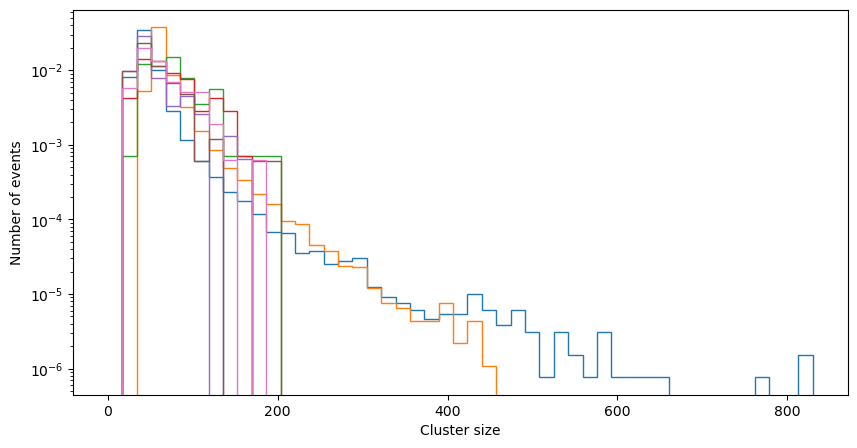

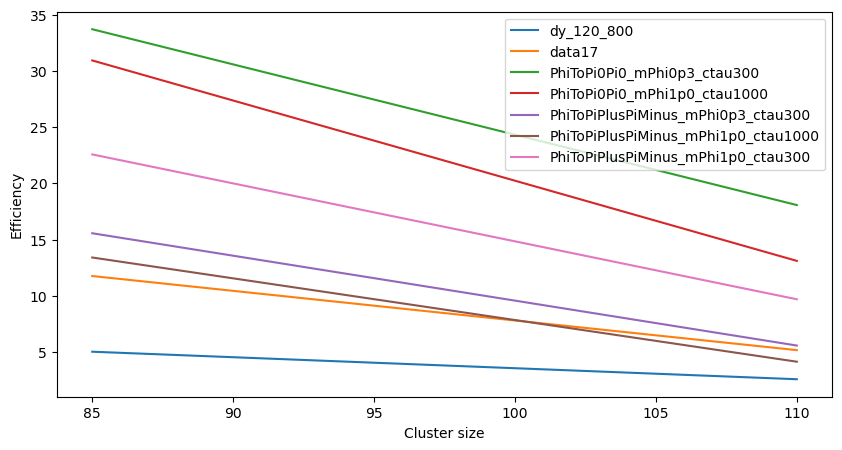

   Cut values  dy_120_800  data17  PhiToPi0Pi0_mPhi0p3_ctau300  PhiToPi0Pi0_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi0p3_ctau300  PhiToPiPlusPiMinus_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi1p0_ctau300
0        85.0        5.01   11.75                        33.73                         30.95                               15.56                                13.40                               22.58
1       110.0        2.56    5.15                        18.07                         13.10                                5.56                                 4.12                                9.68
   Cut values  dy_120_800  data17  PhiToPi0Pi0_mPhi0p3_ctau300  PhiToPi0Pi0_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi0p3_ctau300  PhiToPiPlusPiMinus_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi1p0_ctau300
0          85        3858    6351                           28                            26                                  14                                   13                           

In [7]:
keys = list(dtRechitClusterSize.keys())
max_values = [max(i) for i in list(dtRechitClusterSize.values())]
a = 5
fig, ax = plt.subplots(1, figsize = (a*2, a*1))
fig_eff, ax_eff = plt.subplots(1, figsize = (a*2, a*1))
cut_values = [85, 110] # np.linspace(0, 40, 81) * 10
columns = ["Cut values"]
data_matrix = []
signal_yield = []
data_matrix.append(cut_values)
signal_yield.append(cut_values)
# print(cut_values)
for i in range(len(keys)):
    key = keys[i]
    # if "Phi" in keys[i]: continue
    eff = []
    signal_y = []
    variable = np.array(dtRechitClusterSize[key])
    for j in cut_values:
        eff.append(np.around(np.sum(variable > j)*100/len(variable), 2))
        signal_y.append(len(variable[variable > j]))
    # print(50, key, np.round(np.sum(variable > 50)*100/len(variable), 2))
    # print(390, key, np.round(np.sum(variable > 390)*100/len(variable), 2))
    # print()
    columns.append(key)
    data_matrix.append(eff)
    signal_yield.append(signal_y)
    bins = np.linspace(0, max(max_values), 50)
    ax.hist(variable, bins = bins, histtype = "step", label = keys[i], density = True)
    # print(eff)
    ax_eff.plot(cut_values, eff, label = keys[i])
ax.set_yscale("log")
ax.set_xlabel("Cluster size")
ax.set_ylabel("Number of events")

ax_eff.set_xlabel("Cluster size")
ax_eff.set_ylabel("Efficiency")

plt.legend()
plt.show()

data_frame = pd.DataFrame(data = np.array(data_matrix).T, columns = columns)
print(data_frame.to_string())

data_frame_1 = pd.DataFrame(data = np.array(signal_yield).T, columns = columns)
print(data_frame_1.to_string())

# print("Data, MC, WP, signal yield, ")

In [8]:
signal_yield

[[85, 110],
 [3858, 1973],
 [6351, 2782],
 [28, 15],
 [26, 11],
 [14, 5],
 [13, 4],
 [21, 9]]

In [10]:
for i in [3,4,5,6,7]:
    print((signal_yield[i][0] - signal_yield[i][1]) / signal_yield[i][1])

0.8666666666666667
1.3636363636363635
1.8
2.25
1.3333333333333333


# Make the efficiency plots and get the inclusive efficiencies with errors.

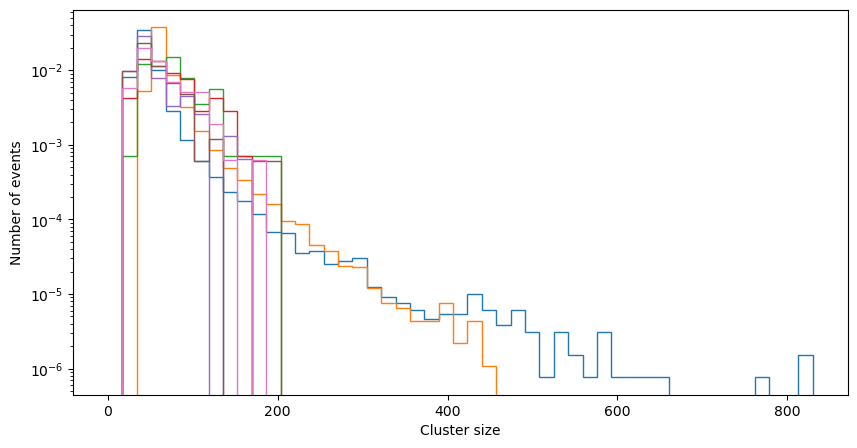

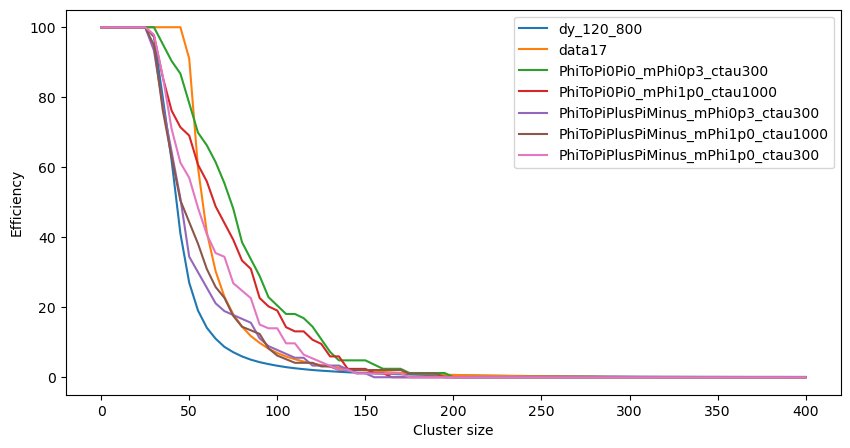

    Cut values  dy_120_800  data17  PhiToPi0Pi0_mPhi0p3_ctau300  PhiToPi0Pi0_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi0p3_ctau300  PhiToPiPlusPiMinus_mPhi1p0_ctau1000  PhiToPiPlusPiMinus_mPhi1p0_ctau300
0          0.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
1          5.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
2         10.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                              100.00
3         15.0      100.00  100.00                       100.00                        100.00                              100.00                               100.00                      

In [6]:
keys = list(dtRechitClusterSize.keys())
max_values = [max(i) for i in list(dtRechitClusterSize.values())]
a = 5
fig, ax = plt.subplots(1, figsize = (a*2, a*1))
fig_eff, ax_eff = plt.subplots(1, figsize = (a*2, a*1))
cut_values = np.linspace(0, 40, 81) * 10
columns = ["Cut values"]
data_matrix = []
signal_yield = []
data_matrix.append(cut_values)
signal_yield.append(cut_values)
# print(cut_values)
for i in range(len(keys)):
    key = keys[i]
    # if "Phi" in keys[i]: continue
    eff = []
    signal_y = []
    variable = np.array(dtRechitClusterSize[key])
    for j in cut_values:
        eff.append(np.around(np.sum(variable > j)*100/len(variable), 2))
        signal_y.append(len(variable[variable > j]))
    # print(50, key, np.round(np.sum(variable > 50)*100/len(variable), 2))
    # print(390, key, np.round(np.sum(variable > 390)*100/len(variable), 2))
    # print()
    columns.append(key)
    data_matrix.append(eff)
    signal_yield.append(signal_y)
    bins = np.linspace(0, max(max_values), 50)
    ax.hist(variable, bins = bins, histtype = "step", label = keys[i], density = True)
    # print(eff)
    ax_eff.plot(cut_values, eff, label = keys[i])
ax.set_yscale("log")
ax.set_xlabel("Cluster size")
ax.set_ylabel("Number of events")

ax_eff.set_xlabel("Cluster size")
ax_eff.set_ylabel("Efficiency")

plt.legend()
plt.show()

data_frame = pd.DataFrame(data = np.array(data_matrix).T, columns = columns)
print(data_frame.to_string())

data_frame_1 = pd.DataFrame(data = np.array(signal_yield).T, columns = columns)
print(data_frame_1.to_string())

# print("Data, MC, WP, signal yield, ")

eta phi to calculate simple DeltaR
eta phi to calculate simple DeltaR
1.0003059601947732 0.0006607003889350465 1.0005860750956868 0.0009133431448852418
1.0003314548488187 0.0005125038768240837 1.0008396029230802 0.0008158791850184346
1.0005911630949242 0.0013367736790506992 1.0014370512892632 0.0008101706611729835
1.000860070995112 0.0008705240460066064 1.0003070449221643 0.0007220462584780246
0.9990544028652305 0.007028714176866708 1.0030274997148 0.001383634662648856
eta phi to calculate simple DeltaR
eta phi to calculate simple DeltaR
1.001798524858281 0.0006676083959491704 1.0016381105075787 0.0009244962446167915
1.00102821099239 0.0005101940543255997 1.0017992412344985 0.0008385803394417633
1.003064112768511 0.0014120779538088386 1.0019963507930427 0.0008017060115054135
1.0010641885899554 0.0008583908894835006 1.001654282245467 0.0007325994264036962
1.0112039849774042 0.010992772352468965 0.999661698062818 0.001266087610212856
eta phi to calculate simple DeltaR
eta phi to calculat

Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWei

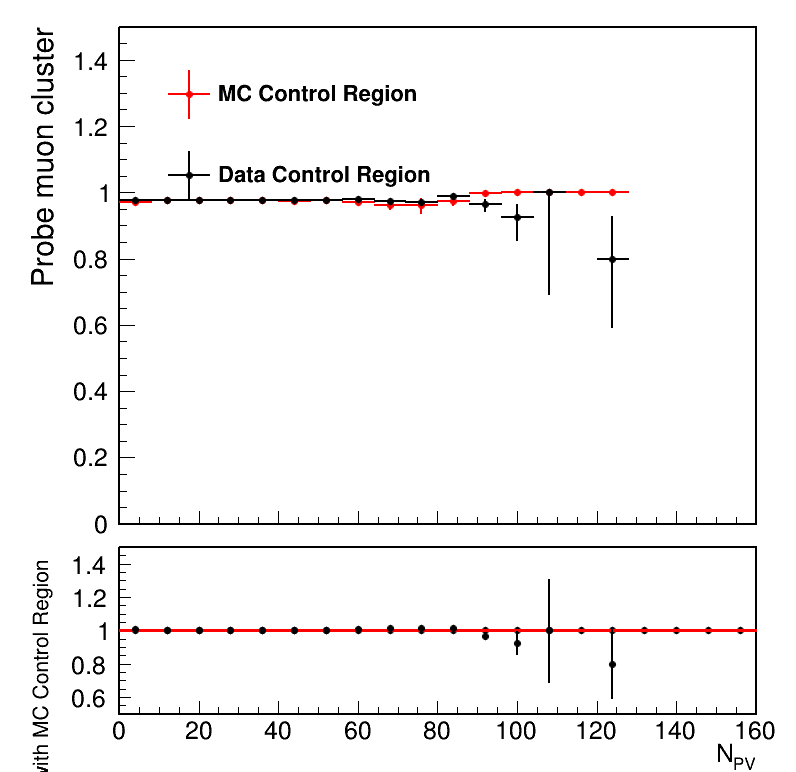

In [6]:
###########
# 0: RPC matching veto; 1:muon veto; 2: MB1 veto; 3: MB1 adjacent veto; 4: Jet veto;
###########

var_eta = [rpc_eta, muonEta, mb1_eta, corr_eta, jetEta, mb1_eta, probe_muonEta] # For DT
var_phi = [rpc_phi, muonPhi, mb1_phi, corr_phi, jetPhi, mb1_phi, probe_muonPhi]

veto = 3
integral = {}
dr_mb1 = {}
rpc_sel = {}
for signal in signal_samples:
    signal = signal.split(".root")[0]
    matched = {}
    diff = {}
    diff_err = {}
    eff_data_err = {}
    eff_dy_err = {}
    eff_data = {}
    eff_dy = {}

    for veto in range(len(veto_names)):
        if veto != 6: continue # SELECTIONS OF THE VETO
        matched = {}
        for k in ['data17', 'dy_120_800']:
            hist, bins = np.histogram(np.abs(list(dtRechitClusterEta[signal])),bins = 48,range=[0.8,2.0],weights = list(weight[signal]))
            hist_wheel, bins_wheel = np.histogram(np.abs(list(dtRechitClusterWheel[signal])),bins = 10,range=[-5,5],weights = list(weight[signal]))

            bin_width = bins[1]-bins[0]
            bin_midpoints = bins[:-1] + np.diff(bins)/2
            cdf = np.cumsum(hist)
            cdf = cdf / cdf[-1]
            values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
            pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))-0.5)*bin_width
            signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
            signs[signs <  0.5] = -1
            signs[signs >= 0.5] =  1
            value_bins = np.searchsorted(cdf, values)

            eta = bin_midpoints[value_bins]*signs+pos_in_bin
            phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[veto][k]))/180.0*math.pi

            bin_width = bins_wheel[1]-bins_wheel[0]
            bin_midpoints = bins_wheel[:-1]
            cdf = np.cumsum(hist_wheel)
            cdf = cdf / cdf[-1]
            values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
            pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k])))*bin_width
            signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
            signs[signs < 0.5] = -1
            signs[signs >= 0.5] = 1
            value_bins = np.searchsorted(cdf, values)

            wheel = bin_midpoints[value_bins]*signs+pos_in_bin
            wheel = np.round(wheel)

            if veto_names[veto] == "rpc_matching_veto":   
                dPhi = deltaPhi(phi, var_phi[veto][k][np.repeat(np.arange(len(var_phi[veto][k])), CLUSTER_PER_EVT)])
                ring = (wheel == rpc_ring[k][np.repeat(np.arange(len(rpc_ring[k])), CLUSTER_PER_EVT)])
                selecting = (np.abs(dPhi) < 0.5) & (ring)
                rpc_sel[k] = ak.sum(selecting, axis = 1)
                matched[k] = (ak.sum(selecting, axis = 1) > 1)
            elif veto_names[veto] == "mb1_adjacent_veto":
                sel_1 = (np.abs(wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)]-wheel) == 1) & (wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)] == 1)
                sel_2 = (np.abs(deltaPhi(var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)], phi)) < np.pi/4.0)
                sel_3 = ((wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)]-wheel)==1)
                mb1_cosmics_plus  = sel_1 & sel_2 & sel_3
                mb1_cosmics_minus = sel_1 & sel_2 & (np.logical_not(sel_3))
                matched[k] = (ak.sum(mb1_cosmics_plus, axis = 1) > 8) | (ak.sum(mb1_cosmics_minus, axis = 1) > 8)
            elif veto_names[veto] == "mb1_veto":
                deltaR = ((var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)] - eta)**2 + \
                          deltaPhi(var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)] , phi)**2)**0.5
                selecting = (deltaR < 0.5)
                dr_mb1[k] = ak.sum(selecting, axis = 1)
                matched[k] = (dr_mb1[k] > 5)
            elif veto_names[veto] == "rec_seg_veto":
                dPhi = deltaPhi(phi, rpc_phi[k][np.repeat(np.arange(len(rpc_phi[k])), CLUSTER_PER_EVT)])
                ring = (wheel == rpc_ring[k][np.repeat(np.arange(len(rpc_ring[k])), CLUSTER_PER_EVT)])
                selecting_rpc = (np.sum((np.abs(dPhi) < 0.5) & (ring)) > 1)
                
                sel_1 = (np.abs(wheels[k][np.repeat(np.arange(len(mb1_eta[k])), CLUSTER_PER_EVT)]-wheel) == 1) & (wheels[k][np.repeat(np.arange(len(mb1_eta[k])), CLUSTER_PER_EVT)] == 1)
                sel_2 = (np.abs(deltaPhi(mb1_phi[k][np.repeat(np.arange(len(mb1_eta[k])), CLUSTER_PER_EVT)], phi)) < np.pi/4.0)
                sel_3 = ((wheels[k][np.repeat(np.arange(len(mb1_phi[k])), CLUSTER_PER_EVT)]-wheel)==1)
                mb1_cosmics_plus  = sel_1 & sel_2 & sel_3
                mb1_cosmics_minus = sel_1 & sel_2 & (np.logical_not(sel_3))
                selecting_mb1_adjacent = (np.sum((ak.sum(mb1_cosmics_plus, axis = 1) > 8) | (ak.sum(mb1_cosmics_minus, axis = 1) > 8)) > 1)
                
                deltaR = ((corr_eta[k][np.repeat(np.arange(len(corr_eta[k])), CLUSTER_PER_EVT)] - eta)**2 + \
                deltaPhi(corr_phi[k][np.repeat(np.arange(len(corr_eta[k])), CLUSTER_PER_EVT)] , phi)**2)**0.5
                selecting_mb1 = (np.sum((deltaR < 0.5)) > 1)
                
                selecting = selecting_rpc & selecting_mb1_adjacent & selecting_mb1
                matched[k] = selecting # (ak.sum(selecting, axis = 1) > 1)
            else:
                print("eta phi to calculate simple DeltaR")
                deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
                          deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
                matched[k] = ak.any(deltaR < 0.4, axis = 1)
                
        c = rt.TCanvas('c','c', 600, 400)
        leg = rt.TLegend(0.2,0.80,0.4,0.90)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        hm = {}
        hb = {}
        pEff = {}
        var = [ZMass, ZPt, nJets, nJets2, npv]
        title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets', 'N_{PV}']
        bins = [ [25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15],  [20,0,160]]
        names = ['ZMass', 'ZPt', 'nJets', 'nJets_eta2', 'npv']
        ratio = [[0.5,1.5], [0.5,1.5], [0.5,1.5],[0.5,1.5],[0.5,1.5]]
        assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )
        dir_name = f"./Veto_efficiency_{signal}/"
        os.system(f"mkdir -p {dir_name}")
        reweight = 0
        reweight_index = 1
        for j in range(len(bins)):
            inc_int = {}
            inc_int_err = {}
            for i, k in enumerate(['data17', 'dy_120_800', signal]):
                if k == signal and j != 4:continue
                total_weight = weight[k]
                if k == 'data': total_weight = total_weight * 0.0 + 1
                ###########
                # reweight
                ##########
                if k == 'dy_120_800' and reweight:
                    h_reweight = {}
                    h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
                    h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
                    for key, v in h_reweight.items():v.Scale(1./v.Integral())
                    h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
                    reweight = []
                    for m in range(len(var[j][k])):
                        reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
                    total_weight = total_weight * np.array(reweight)

                if k == signal:
                    outside = np.ones(len(dtRechitClusterEta[signal]), dtype = bool)
                    nominator = np.ones(len(dtRechitClusterEta[signal]), dtype = bool)
                    hm[k] = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[nominator]) 
                    hb[k] = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[outside])
                    m = create_TH1D(np.abs(var[j][k][nominator]), 'hm1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[nominator]) 
                    b = create_TH1D(np.abs(var[j][k][outside]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[outside])
                    pEff_inclusive = rt.TEfficiency(m,b)

                else:
                    hm[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                        axis_title = [title[j],veto_yaxis[veto]], binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
                    hb[k] = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                        binning=bins[j], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
                    m = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]), 'hm1',\
                                        axis_title = [title[j],veto_yaxis[veto]], binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)][np.logical_not(matched[k])]) 
                    b = create_TH1D(np.abs(var[j][k][np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)]), 'hb1', axis_title = [title[j],veto_yaxis[veto]], \
                                            binning=[1,0,1000], weights = total_weight[np.repeat(np.arange(len(jetPt[k])), CLUSTER_PER_EVT)])
                    pEff_inclusive = rt.TEfficiency(m,b)
                    inc_int[k] = pEff_inclusive.GetEfficiency(1)
                    inc_int_err[k] = pEff_inclusive.GetEfficiencyErrorUp(1)

                pEff[k] = rt.TEfficiency(hm[k],hb[k])
                pEff[k].SetLineColor(std_color_list[i])
                pEff[k].SetMarkerColor(std_color_list[i])
                pEff[k].SetLineWidth(2)

            diff        [veto_names[veto]] = inc_int["data17"] / inc_int["dy_120_800"]
            eff_data    [veto_names[veto]] = inc_int["data17"] * 100
            eff_dy      [veto_names[veto]] = inc_int["dy_120_800"] * 100

            eff_data_err[veto_names[veto]] = inc_int_err["data17"] * 100
            eff_dy_err  [veto_names[veto]] = inc_int_err["dy_120_800"] * 100
            diff_err    [veto_names[veto]] = diff[veto_names[veto]] * np.sqrt((eff_data_err[veto_names[veto]] / eff_data[veto_names[veto]])**2 + (eff_dy_err[veto_names[veto]] / eff_dy[veto_names[veto]])**2)

            c = make_ratio_pEff([pEff['dy_120_800'],pEff['data17']], fit = False, logy=False, in_tags = ["MC Control Region","Data Control Region"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
            c.Draw()

            if reweight: 
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'_reweight'+names[reweight_index]+'.png')
            else:
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.png')
                c.SaveAs(dir_name+veto_names[veto]+'_eff'+names[j]+'.C')
    integral[k] = {"diff": diff, "eff_data": eff_data, "eff_dy": eff_dy, "diff_err": diff_err, "eff_data_err": eff_data_err, "eff_dy_err": eff_dy_err}

[1. 1. 1. ... 1. 1. 1.]
[14.2, 8.68, -18.7, 12, 7.29, 14, ... 0.112, 0.126, 0.121, 0.164, 0.00698, 0.00964]
[44, 31, 69, 49, 35, 54, 35, 78, 30, 34, ... 51, 46, 43, 55, 58, 34, 42, 49, 56, 35]
[55, 57, 60, 68, 69, 50, 171, 56, 52, 57, ... 56, 55, 58, 80, 51, 63, 81, 64, 51, 51]
The efficiency of the ClusterSize > 220 (Data): 0.4533510972946967
The efficiency of the ClusterSize > 220 (MC): 0.24841449908038105
Diff: 1.0607588896579256

Scan the cut values.

Cut value: 0
The efficiency of the ClusterSize > 0 (Data): 0.4533510972946967
The efficiency of the ClusterSize > 0 (MC): 100.0
Diff: 0.004533510972946967

Cut value: 10
The efficiency of the ClusterSize > 10 (Data): 0.4533510972946967
The efficiency of the ClusterSize > 10 (MC): 100.0
Diff: 0.004533510972946967

Cut value: 20
The efficiency of the ClusterSize > 20 (Data): 0.4533510972946967
The efficiency of the ClusterSize > 20 (MC): 100.0
Diff: 0.004533510972946967

Cut value: 30
The efficiency of the ClusterSize > 30 (Data): 0.453

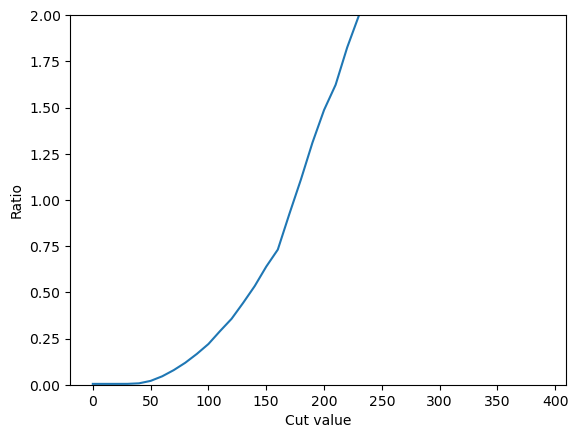

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


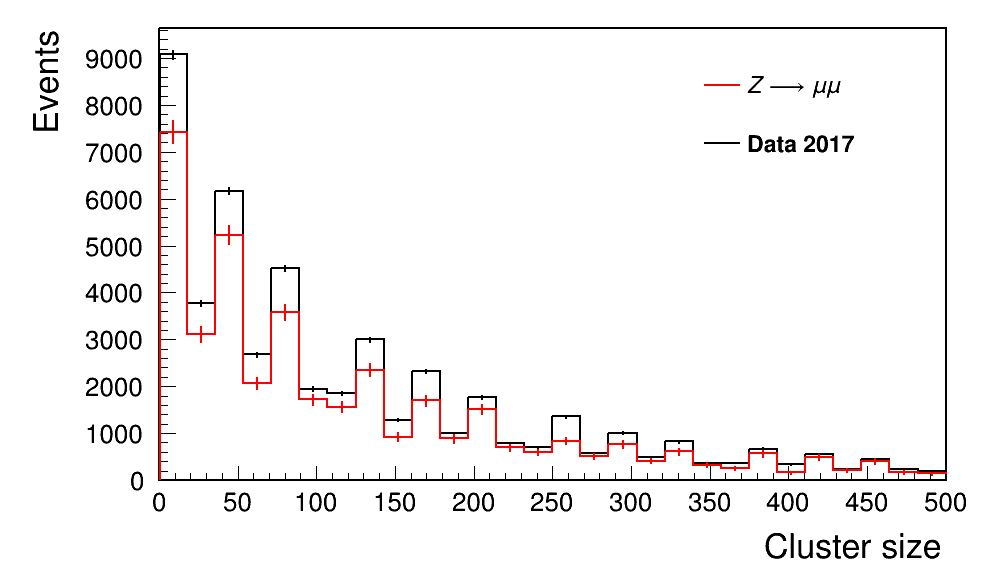

In [7]:
c = rt.TCanvas("", "", 1000, 600)
l = rt.TLegend(0.7, 0.7, 0.9, 0.9)

data = clusterSize['data17'][ak.count(clusterSize['data17'], axis = 1) != 0][:,0]
MC = clusterSize['dy_120_800'][ak.count(clusterSize['dy_120_800'], axis = 1) != 0][:,0]
data_weight = weight["data17"][ak.count(clusterSize['data17'], axis = 1) != 0]
MC_weight = weight["dy_120_800"][ak.count(clusterSize['dy_120_800'], axis = 1) != 0]

print(data_weight)
print(MC_weight)
print(MC)
print(data)

clusterSize_data = create_TH1D(data, weights = data_weight)
clusterSize_MC   = create_TH1D(MC, weights = MC_weight)

clusterSize_MC.GetXaxis().SetTitle("Cluster size")
clusterSize_data.GetXaxis().SetTitle("Cluster size")

clusterSize_MC.SetLineColor(rt.kRed)
clusterSize_data.SetLineColor(rt.kBlack)

clusterSize_MC.SetMarkerSize(0)
clusterSize_data.SetMarkerSize(0)

clusterSize_MC.GetYaxis().SetTitle("Events")
clusterSize_data.GetYaxis().SetTitle("Events")

clusterSize_MC.GetXaxis().SetLimits(0, 500)
clusterSize_data.GetXaxis().SetLimits(0, 500)

l.AddEntry(clusterSize_MC, "Z \longrightarrow \mu \mu")
l.AddEntry(clusterSize_data, "Data 2017")
clusterSize_data.Draw("hist E")
clusterSize_MC.Draw("SAME hist E")
l.Draw("same")
c.Draw()

diff = []

print(f"The efficiency of the ClusterSize > 220 (Data): {100 * len(data[data > 220]) / len(data)}")
print(f"The efficiency of the ClusterSize > 220 (MC): {100 * sum(MC_weight[MC > 220]) / sum(MC_weight)}")
print(f"Diff: {(abs((len(data[data > 220]) / len(data)) / (len(MC[MC > 220]) / len(MC))))}")
print()
print("Scan the cut values.")
for i in range(0, 400, 10):
    print()
    print(f"Cut value: {i}")
    print(f"The efficiency of the ClusterSize > {i} (Data): {100 * len(data[data > 220]) / len(data)}")
    print(f"The efficiency of the ClusterSize > {i} (MC): {100 * sum(MC_weight[MC > i]) / sum(MC_weight)}")
    print(f"Diff: {(abs((len(data[data > 220]) / len(data)) / (sum(MC_weight[MC > i]) / sum(MC_weight))))}")
    diff.append((abs((len(data[data > 220]) / len(data)) / (sum(MC_weight[MC > i]) / sum(MC_weight)))))
plt.plot(range(0, 400, 10), diff)
plt.ylabel("Ratio")
plt.ylim(0, 2)
plt.xlabel("Cut value")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))
for i in ['data17', 'dy_120_800']:
    weights = np.ones(len(rpc_sel[i]))/len(rpc_sel[i])
    print(rpc_sel[i])
    ax.hist(rpc_sel[i], label = i, weights = weights, bins = 250, histtype = "step", linewidth=2)
    plt.xlim(0, 10)
    ax.set_ylabel("Fraction of events")
    ax.set_xlabel("Number of matched RPC hits")
plt.legend()
plt.show()

# Print the inclusive efficiencies.

In [6]:
total_integral_data = []
total_integral_dy = []
total_integral_diff = []
total_integral_data_err = []
total_integral_dy_err = []
total_integral_diff_err = []
rows = []
for i in signal_samples:
    i = i.split(".root")[0]
    key = list(integral[i]["eff_data"].keys())[0]
    rows.append(f'{i} : {key}')
    total_integral_data.append(integral[i]["eff_data"][key])
    total_integral_dy.append(integral[i]["eff_dy"][key])
    total_integral_diff.append(integral[i]["diff"][key])
    total_integral_data_err.append(integral[i]["eff_data_err"][key])
    total_integral_dy_err.append(integral[i]["eff_dy_err"][key])
    total_integral_diff_err.append(integral[i]["diff_err"][key])
table     = {"": rows, "Data efficiency (%)": total_integral_data, "DY efficiency (%)": total_integral_dy, "Efficiency relation (Data / MC)": total_integral_diff}
table_err = {"": rows, "Data efficiency (%)": total_integral_data_err, "DY efficiency (%)": total_integral_dy_err, "Efficiency relation (Data / MC)": total_integral_diff_err}
print(pd.DataFrame(table))
print(pd.DataFrame(table_err))

                                                      Data efficiency (%)  \
0   PhiToPi0Pi0_mPhi0p3_ctau300 : probe_muon_cluster            97.377189   
1  PhiToPi0Pi0_mPhi1p0_ctau1000 : probe_muon_cluster            97.674385   
2  PhiToPiPlusPiMinus_mPhi0p3_ctau300 : probe_muo...            98.153146   
3  PhiToPiPlusPiMinus_mPhi1p0_ctau1000 : probe_mu...            97.766208   
4  PhiToPiPlusPiMinus_mPhi1p0_ctau300 : probe_muo...            98.151181   

   DY efficiency (%)  Efficiency relation (Data / MC)  
0          97.254873                         1.001258  
1          97.582330                         1.000943  
2          98.094898                         1.000594  
3          97.736652                         1.000302  
4          98.145311                         1.000060  
                                                      Data efficiency (%)  \
0   PhiToPi0Pi0_mPhi0p3_ctau300 : probe_muon_cluster             0.012150   
1  PhiToPi0Pi0_mPhi1p0_ctau1000 : probe_muon_cl

# Plotting variables.

In [ ]:
keys = list(dtRechitClusterSize.keys())
max_values = [max(i) for i in list(dtRechitClusterSize.values())]
print(values)
a = 5
fig, ax = plt.subplots(1, figsize = (a*2, a))
for i in range(len(keys)):
    key = keys[i]
    variable = dtRechitClusterSize[key]
    print(key, variable)
    bins = np.linspace(0, max(max_values), 50)
    ax.hist(variable, bins = bins, histtype = "step", label = keys[i])
ax.set_yscale("log")
plt.legend()
plt.plot()

In [ ]:
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
# var   = [ZMass, ZPt, nJets, nJets2,npv]
# title = ['Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'Number of Jets', 'Number of Jets','npv']
# bins  = [[25,120,800], [0,20,40,60,80,100,200,300,400,500,600,1200], [10,0,20], [15,0,15], [20,0,160]]
# names = ['ZMass','ZPt', 'nJets','nJets_eta2', 'npv']
# ratio = [[0.5,1.5], [0.0,2], [0.5,1.5],[0.5,3],[0.5,5]]

# var   = [nMuons, mb1_eta, mb1_phi, stations]
# title = ['NMuons', "mb1_eta", "mb1_phi", "stations"]
# bins  = [[20, 0, 20], [30, 0, 4], [30, -4, 4], [10, 0, 5]]
# names = ['NMuons', "mb1_eta", "mb1_phi", "stations"]
# ratio = [[0.5,1.5], [-1.5,1.5], [-1.5,1.5], [-1.5, 1.5]]

var   = [mb1_eta, mb1_phi]
title = ["mb1_eta", "mb1_phi"]
bins  = [[30, -4, 4], [30, -4, 4]]
names = ["mb1_eta", "mb1_phi"]
ratio = [[-1.5,1.5], [-1.5,1.5]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

# dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/jet_veto_eff/'
dir_name = './Veto_efficiency/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)

datasets = ["data17", "dy_120_800"]

reweight  = 0
reweight_index = 1
for j in range(len(bins)):
    c = rt.TCanvas('c','c', 1600, 1200)
    # if not j == 1: continue
    for i, k in enumerate(datasets):
        total_weight = weight[k]
        # print(weight[k][0])
#         if 'dy' in k: total_weight *= lepOverallSF[k]
        if 'data17' in k: total_weight = total_weight * 0.0 + 1
        ###########
        # reweight
        ##########
        if ('dy' in k) and reweight:
            print(np.sum(total_weight))
            h_reweight = {}
            print("reweight",names[reweight_index], "plot", names[j])
            h_reweight['mc_reweight'] = create_TH1D( np.abs(var[reweight_index][k]), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data17']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index])
            for key, v in h_reweight.items():v.Scale(1./v.Integral())
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(var[j][k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index][k])[m])))
            total_weight = total_weight * reweight
        # print(k, len(var[j][k]))
        # if "dy" in k:
        # print(var[j][k].layout.minmax_depth)
        if var[j][k].layout.minmax_depth == (1,1):
            print()
            print((1,1))
            print(title[j])
            print(len(np.abs(var[j][k])))
            print(len(total_weight))
            h[k] = create_TH1D(var[j][k], 'hm1', axis_title = [title[j],'Events'], binning=bins[j])
        else:
            variable = ak.flatten(var[j][k], axis = 1)
            tot_weights = np.ones_like(variable) / len(variable) # [ak.count(var[j][k], axis=1) > 0]
            print()
            print((2,2))
            print(title[j])
            print(variable)
            print(tot_weights)
            h[k] = create_TH1D(variable, 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = tot_weights)
        # else:
        #    h[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j]) # , weights = total_weight)
        h[k].SetLineColor(std_color_list[i])
        h[k].SetLineWidth(3)
        h[k].Scale(1.0/h[k].Integral())
        h[k].GetYaxis().SetRangeUser(0, 1)
        h[k].Draw("SAME HIST")
        # print(k,h[k].Integral(),len(total_weight))
    # c = make_ratio_plot([h['dy_120_800'],h['data17']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
    c.Draw()
    
    if not reweight:
        c.SaveAs(dir_name+names[j]+'.png')
        c.SaveAs(dir_name+names[j]+'.C')
    else:
        c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')
        c.SaveAs(dir_name+names[j]+'_reweight'+names[reweight_index]+'.png')


In [ ]:
for i in dr_mb1.keys():
    print(i)
    print(np.sum(ak.any((dr_mb1[i]), axis = 1) < 0.5)/len(ak.any(dr_mb1[i], axis = 1)))

In [ ]:
dr_mb1["data17"]

In [ ]:
print(ak.sum(ak.sum(dr_mb1["data17"] < 0.5, axis = 1) <= 1) / len(dr_mb1["data17"]))
print(ak.sum(ak.sum(dr_mb1["dy_120_800"] < 0.5, axis = 1) <= 1) / len(dr_mb1["dy_120_800"]))

In [ ]:
data = dr_mb1["data17"][dr_mb1["data17"] < 0.5]
weights_data = np.ones_like(ak.count(data, axis = 1)) / len(ak.count(data, axis = 1))
mc = dr_mb1["dy_120_800"][dr_mb1["dy_120_800"] < 0.5]

print(ak.count(mc, axis = 1))
print(ak.count(data, axis = 1))
# print(hist_dy[0]  , hist_dy[1])

weights_mc = np.ones_like(ak.count(mc, axis = 1)) / len(ak.count(mc, axis = 1))

hist_dy   = plt.hist(ak.count(mc, axis = 1)  , bins = 20, range = (0, 20), weights = weights_mc  , histtype = "step", label = "Drell-Yan")
hist_data = plt.hist(ak.count(data, axis = 1), bins = 20, range = (0, 20), weights = weights_data, histtype = "step", label = "Data 2017")

print(len(hist_dy[1][0: len(hist_dy[0])]), len(hist_dy[0]))
print(len(hist_data[1][0: len(hist_data[0])]), len(hist_data[0]))

plt.errorbar(hist_dy  [1][0: len(hist_dy  [0])],   hist_dy[0], yerr = np.std(  hist_dy[0]))
plt.errorbar(hist_data[1][0: len(hist_data[0])], hist_data[0], yerr = np.std(hist_data[0]))

plt.ylabel("Events")
plt.xlabel("Number of matched MB1 rechits")
plt.legend()
plt.show()

In [ ]:
data = ak.sum(dr_mb1["data17"] < 0.5, axis = 1)
weights_data = np.ones_like(data) / len(data)
mc = ak.sum(dr_mb1["dy_120_800"] < 0.5, axis = 1)
weights_mc = np.ones_like(mc) / len(mc)
plt.hist(mc  , bins = 50, range = (0, 20), weights = weights_mc  , histtype = "step", label = "Drell-Yan")
plt.hist(data, bins = 50, range = (0, 20), weights = weights_data, histtype = "step", label = "Data 2017")
plt.ylabel("Events")
plt.xlabel("Number of matched MB1 rechits")
plt.legend()
plt.show()

In [ ]:
print(np.sum(data <= 1) / len(data))
print(np.sum(mc   <= 1) / len(mc  ))

In [ ]:
print(ak.sum(data <= 5)/len(data))
print(ak.sum(mc   <= 5)/  len(mc))

In [ ]:
ak.count(dr_mb1["dy_120_800"][dr_mb1["dy_120_800"] < 0.5], axis = 1)

In [ ]:
data = ak.sum(dr_mb1["data17"    ] < 0.5, axis = 1)
weights_data = np.ones_like(data) / len(data)
mc   = ak.sum(dr_mb1["dy_120_800"] < 0.5, axis = 1)
weights_mc   = np.ones_like(mc)   / len(mc)
plt.hist(mc  , bins = 100, range = (0, 20), weights = weights_mc  , histtype = "step", label = "Drell-Yan")
plt.hist(data, bins = 100, range = (0, 20), weights = weights_data, histtype = "step", label = "Data 2017")
plt.ylabel("Events")
plt.xlabel("Number of matched MB1 rechits")
plt.legend()
plt.show()

In [ ]:
data = ak.flatten(mb1_phi["data17"], axis = 1)
weights_data = np.ones_like(data) / len(data)
mc = ak.flatten(mb1_phi["dy_120_800"], axis = 1)
weights_mc = np.ones_like(mc) / len(mc)
plt.hist(mc  , bins = 20, range = (-4, 4), weights = weights_mc, histtype = "step", label = "Drell-Yan")
plt.hist(data, bins = 20, range = (-4, 4), weights = weights_data, histtype = "step", label = "Data 2017")
plt.ylabel("Events")
plt.xlabel("Number of matched MB1 rechits")
plt.legend()
plt.show()

In [ ]:
data = ak.flatten(mb1_eta["data17"], axis = 1)
weights_data = np.ones_like(data) / len(data)
mc = ak.flatten(mb1_eta["dy_120_800"], axis = 1)
weights_mc = np.ones_like(mc) / len(mc)
plt.hist(mc  , bins = 20, range = (0, 2), weights = weights_mc  , histtype = "step", label = "Drell-Yan")
plt.hist(data, bins = 20, range = (0, 2), weights = weights_data, histtype = "step", label = "Data 2017")
plt.ylabel("Events")
plt.xlabel("Number of matched MB1 rechits")
plt.legend()
plt.show()

In [ ]:
print(ak.sum(data <= 1)/len(data))
print(ak.sum(mc   <= 1)/  len(mc))

In [ ]:
plt.hist(ak.count(dr_mb1["dy_120_800"][dr_mb1["dy_120_800"] < 0.5], axis = 1), bins = 100, range = (0, 25))
plt.show()

In [ ]:
plt.hist(ak.count(dr_mb1["data17"][dr_mb1["data17"] < 0.5], axis = 1), bins = 100, range = (0, 25))
plt.show()

In [ ]:
plt.hist(ak.flatten(arrays["dtRechitClusterMaxStation"][arrays["dtRechitClusterMaxStation"] != 1]))
plt.show()

In [ ]:
            # wheel_ranges = np.array([(-675 + i * 270, -675 + (i+1) * 270) for i in range(0, 5)])
            # wheel_index = np.array(range(-2, 3, 1))
            # print(len(wheel_index))
            
            # def sel(eta):
            #     r_min = 400
            #     r_max = 740
            #     theta = 2 * np.arctan(math.e**(-1 * eta))
            #     x = (r_min * np.sinh(eta)/np.cosh(eta), r_max * np.sinh(eta)/np.cosh(eta))
            #     x_min = min(x)
            #     x_max = max(x)
            #     # print(wheel_ranges)
            #     # print(x_min, x_max)
            #     sel_max = [(x_max < w_r[1]) for w_r in wheel_ranges]
            #     sel_min = [(x_min > w_r[0]) for w_r in wheel_ranges]
            #     # print(sel_max)
            #     # print(sel_min)
            #     wheels_min = np.max(wheel_index[sel_min])
            #     wheels_max = np.min(wheel_index[sel_max])
            #     # print(wheels_min, wheels_max)
            #     wheel = (np.round((wheels_max - wheels_min) * np.random.rand() + wheels_min))
            #     # print(wheel)
            #     return wheel

            # for w, wheel_r in enumerate(wheel_ranges):
            #     wheels_min.append(wheel_index[w] * (wheels_r < x_min))
            #     wheels_max.append(wheel_index[w] * (wheels_r > x_max))
            # ak.apply()
            
            # wheel = np.apply_along_axis(func1d = np.round, arr = np.array(bin_midpoints[value_bins]*signs+pos_in_bin), axis = 0)

            #    find_wheels = np.vectorize(sel)
            #    wheel = find_wheels(list(eta))

            '''
                eta = bin_midpoints[value_bins]*signs+pos_in_bin # for phi, randomly pick a point between 0,360
                phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[veto][k]))/180.0*math.pi
                # calculate deltaR between cluster the the jet/hits
                deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
                          deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
                matched[k] = ak.any(deltaR<0.4, axis = 1)
            '''
                # for k in ['data17', 'dy_120_800']:
        # dist, bins = np.histogram(np.abs(list(dtRechitClusterEta[signal])),bins = 48,range=[0.8,2.0],weights = list(weight[signal]))
        # hist_wheel, bins_wheel = np.histogram(np.abs(list(dtRechitClusterWheel[signal])),bins = 20,range=[-5,5],weights = list(weight[signal]))

        # bin_width = bins[1]-bins[0]
        # bin_midpoints = bins[:-1] + np.diff(bins)/2
        # cdf = np.cumsum(hist)
        # cdf = cdf / cdf[-1]
        # values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        # pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))-0.5)*bin_width
        # signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        # signs[signs < 0.5] = -1
        # signs[signs >= 0.5] = 1
        # value_bins = np.searchsorted(cdf, values)

        # eta = bin_midpoints[value_bins]*signs+pos_in_bin
        # phi = np.random.randint(0,360,CLUSTER_PER_EVT*len(var_eta[veto][k]))/180.0*math.pi

        # bin_width = bins_wheel[1]-bins_wheel[0]
        # bin_midpoints = bins_wheel[:-1] + np.diff(bins_wheel)/2
        # cdf = np.cumsum(hist_wheel)
        # cdf = cdf / cdf[-1]
        # values = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        # pos_in_bin = (np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))-0.5)*bin_width
        # signs = np.random.rand(CLUSTER_PER_EVT*len(var_eta[veto][k]))
        # signs[signs < 0.5] = -1
        # signs[signs >= 0.5] = 1

        #         value_bins = np.searchsorted(cdf, values)
        # wheel = np.apply_along_axis(func1d = np.round, arr = np.array(bin_midpoints[value_bins]*signs+pos_in_bin), axis = 0)

        # if veto_names[veto] == "rpc_matching_veto":
        #     deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
        #                deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
        #     ring   = (wheel == rpc_ring[k][np.repeat(np.arange(len(rpc_ring[k])), CLUSTER_PER_EVT)])
        #     selecting = (deltaR < 0.5) & (ring)
        #     matched[k] = ak.any(selecting, axis = 1)
        # elif veto_names[veto] == "mb1_adjacent_veto":
        #     print(k)
        #     sel_1 = (abs(            wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)]-wheel) == 1) & (wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)] == 1)
        #     sel_2 = (deltaPhi(var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)], phi) < np.pi/4.0)
        #     sel_3 = ((wheels[k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)]-wheel)==1)
        #     # pdb.set_trace()
        #     # print(sel_1)
        #     mb1_cosmics_plus  = sel_1 & sel_2 & sel_3
        #     mb1_cosmics_minus = sel_1 & sel_2 & (np.logical_not(sel_3))
        #     # pdb.set_trace()
        #     matched[k] = (ak.sum(mb1_cosmics_plus, axis = 1) >= 8) | (ak.sum(mb1_cosmics_minus, axis = 1) >= 8)
        #     # (ak.sum(mb1_cosmics_plus, axis = 1) >= 8) & (ak.sum(mb1_cosmics_minus, axis = 1) >= 8)
        # elif veto_names[veto] == "mb1_veto":
        #     deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
        #               deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
        #     print("LOOK AT THE MATCHED -> ", deltaR)
        #     dr_mb1[k] = deltaR # deltaR[ak.count(deltaR, axis = 1) > 0][:, 0]
        #     matched[k] = (ak.sum(deltaR < 0.5, axis = 1) > 1)
        # else:
        #     print("eta phi to calculate simple DeltaR")
        #     deltaR = ((eta-var_eta[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2+ \
        #               deltaPhi(phi,var_phi[veto][k][np.repeat(np.arange(len(var_eta[veto][k])), CLUSTER_PER_EVT)])**2)**0.5
        #     matched[k] = ak.any(deltaR < 0.4, axis = 1)np.logical_not
        # print(k, 1-np.count_nonzero(matched[k])/ len(deltaR))